In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

In [2]:
granger_df_all_T = pd.read_csv('../results_final_Jan15/granger_draft_T_signed_score.csv', index_col=0)
granger_df_all_A = pd.read_csv('../results_final_Jan15/granger_draft_A_signed_score.csv', index_col=0)
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [3]:
granger_df_all_T_pvals = pd.read_csv('../results_final_Jan15/granger_draft_T_p.csv', index_col=0)
granger_df_all_A_pvals = pd.read_csv('../results_final_Jan15/granger_draft_A_p.csv', index_col=0)

granger_df_all_T_pvals.index = granger_df_all_T_pvals.index.str.replace('_x', '')
granger_df_all_T_pvals.columns = granger_df_all_T_pvals.columns.str.replace('_y', '')
granger_df_all_A_pvals.index = granger_df_all_A_pvals.index.str.replace('_x', '')
granger_df_all_A_pvals.columns = granger_df_all_A_pvals.columns.str.replace('_y', '')

In [4]:
cluster_df = pd.read_csv('../results_final_Jan30/cluster_df_extreme_T_draft.csv', index_col=0)

In [5]:
goi = ['ESRRA', 'ZEB1', 'CDH1', 'GAPDH', 'SNAI1', 'AHR', 'ARNT']

In [6]:
assert all(g in adata.var_names for g in goi), "Some genes not found in adata.var_names"

In [7]:
goi

['ESRRA', 'ZEB1', 'CDH1', 'GAPDH', 'SNAI1', 'AHR', 'ARNT']

In [8]:
ranked_df_T =  (granger_df_all_T.abs()
 .reset_index()  # Preserve the index as a column before melting
 .melt(id_vars='index', ignore_index=True)  # Keep index column during melt
 .rename(columns={'variable': 'target', 'index': 'source', 'value': 'granger_score'})
 .sort_values('granger_score', ascending=False)
 .reset_index(drop=True)
)

In [9]:
(ranked_df_T['granger_score'] >= 6.93147).sum()

10851

In [10]:
ranked_df_T_pvals = (
    granger_df_all_T_pvals.reset_index()
    .melt(id_vars='index', ignore_index=True)
    .rename(columns={'variable': 'target', 'index': 'source', 'value': 'pval'})
    .sort_values('pval', ascending=True)
    .reset_index(drop=True)
)
ranked_df_A_pvals = (
    granger_df_all_A_pvals.reset_index()
    .melt(id_vars='index', ignore_index=True)
    .rename(columns={'variable': 'target', 'index': 'source', 'value': 'pval'})
    .sort_values('pval', ascending=True)
    .reset_index(drop=True)
)

In [11]:
ranked_df_T_pvals

,source,target,pval
0,PA2G4,PPIL4,0.000000e+00
1,OSR2,DDX19A,0.000000e+00
2,ZNF667,TERF2IP,0.000000e+00
3,SP1,RGS4,3.547645e-292
4,TBX2,ELMOD2,1.740465e-194
...,...,...,...
2430848,RXRA,RXRA,1.000000e+00
2430849,ZNF385A,ZNF385A,1.000000e+00
2430850,GATA3,GATA3,1.000000e+00
2430851,RARA,RARA,1.000000e+00


In [12]:
ranked_df_T_pvals['log10_pval'] = -np.log10(ranked_df_T_pvals['pval'] + 1e-300)

In [13]:
ranked_df_T_pvals

,source,target,pval,log10_pval
0,PA2G4,PPIL4,0.000000e+00,300.000000
1,OSR2,DDX19A,0.000000e+00,300.000000
2,ZNF667,TERF2IP,0.000000e+00,300.000000
3,SP1,RGS4,3.547645e-292,291.450060
4,TBX2,ELMOD2,1.740465e-194,193.759335
...,...,...,...,...
2430848,RXRA,RXRA,1.000000e+00,-0.000000
2430849,ZNF385A,ZNF385A,1.000000e+00,-0.000000
2430850,GATA3,GATA3,1.000000e+00,-0.000000
2430851,RARA,RARA,1.000000e+00,-0.000000


In [14]:
ranked_df_T_pvals[ranked_df_T_pvals['source'] == 'ESRRA']

,source,target,pval,log10_pval
187,ESRRA,RNF145,2.196373e-47,46.658294
194,ESRRA,LGALS1,1.172008e-46,45.931070
492,ESRRA,ARHGAP8,2.821255e-32,31.549558
695,ESRRA,WDR66,3.616751e-28,27.441681
794,ESRRA,ZNF385A,8.844511e-27,26.053326
...,...,...,...,...
2427484,ESRRA,SLC26A2,9.982865e-01,0.000745
2427900,ESRRA,RUFY3,9.985570e-01,0.000627
2428739,ESRRA,RRP9,9.990431e-01,0.000416
2428974,ESRRA,CEBPB,9.991858e-01,0.000354


In [15]:
total_scores = pd.DataFrame(ranked_df_T_pvals.groupby('source')['log10_pval'].sum())
total_scores['source'] = total_scores.index
total_scores = total_scores.reset_index(drop=True)

In [16]:
total_scores[total_scores['source'].isin(goi)]

,log10_pval,source
4,3475.895146,AHR
16,5213.642171,ARNT
72,4842.532657,ESRRA
273,4159.242098,SNAI1
341,5772.983477,ZEB1


In [17]:
total_scores_T_topk = pd.DataFrame({
    'top1': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(1, 'log10_pval')['log10_pval'].sum()),
    'top5': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(5, 'log10_pval')['log10_pval'].sum()),
    'top10': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(10, 'log10_pval')['log10_pval'].sum()),
    'top100': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(100, 'log10_pval')['log10_pval'].sum()),
    'top1000': ranked_df_T_pvals.groupby('source').apply(lambda x: x.nlargest(1000, 'log10_pval')['log10_pval'].sum()),
    'all': ranked_df_T_pvals.groupby('source')['log10_pval'].sum()
})
total_scores_T_topk['source'] = total_scores_T_topk.index
total_scores_T_topk = total_scores_T_topk.reset_index(drop=True)

# Add rankings for each column
total_scores_T_topk['top1_rank'] = total_scores_T_topk['top1'].rank(ascending=False)
total_scores_T_topk['top5_rank'] = total_scores_T_topk['top5'].rank(ascending=False)
total_scores_T_topk['top10_rank'] = total_scores_T_topk['top10'].rank(ascending=False)
total_scores_T_topk['top100_rank'] = total_scores_T_topk['top100'].rank(ascending=False) 
total_scores_T_topk['top1000_rank'] = total_scores_T_topk['top1000'].rank(ascending=False)
total_scores_T_topk['all_rank'] = total_scores_T_topk['all'].rank(ascending=False)

total_scores_T_topk['cluster'] = total_scores_T_topk['source'].map(cluster_df['cluster'])

In [18]:
total_scores_T_topk[total_scores_T_topk['source'].isin(goi)]

,top1,top5,top10,top100,top1000,all,source,top1_rank,top5_rank,top10_rank,top100_rank,top1000_rank,all_rank,cluster
4,29.022485,72.468878,113.752865,506.791685,1970.431289,3475.895146,AHR,261.0,377.0,390.0,404.0,400.0,394.0,4.0
16,53.516025,181.630467,263.272272,854.933998,3101.240195,5213.642171,ARNT,97.0,72.0,79.0,138.0,112.0,112.0,4.0
72,46.658294,177.633929,287.183831,1047.848362,3128.816127,4842.532657,ESRRA,121.0,76.0,59.0,56.0,108.0,148.0,3.0
273,24.042487,109.423746,190.619869,819.778968,2632.568615,4159.242098,SNAI1,330.0,228.0,183.0,157.0,207.0,257.0,3.0
341,43.647923,160.225269,269.951278,1057.026813,3586.425782,5772.983477,ZEB1,143.0,103.0,74.0,54.0,50.0,70.0,0.0


In [19]:
ranked_df_A_pvals['log10_pval'] = -np.log10(ranked_df_A_pvals['pval'] + 1e-300)

In [20]:
total_scores_A_topk = pd.DataFrame({
    'top1': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(1, 'log10_pval')['log10_pval'].sum()),
    'top5': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(5, 'log10_pval')['log10_pval'].sum()),
    'top10': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(10, 'log10_pval')['log10_pval'].sum()),
    'top100': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(100, 'log10_pval')['log10_pval'].sum()),
    'top1000': ranked_df_A_pvals.groupby('source').apply(lambda x: x.nlargest(1000, 'log10_pval')['log10_pval'].sum()),
    'all': ranked_df_A_pvals.groupby('source')['log10_pval'].sum()
})
total_scores_A_topk['source'] = total_scores_A_topk.index
total_scores_A_topk = total_scores_A_topk.reset_index(drop=True)

# Add rankings for each column
total_scores_A_topk['top1_rank'] = total_scores_A_topk['top1'].rank(ascending=False)
total_scores_A_topk['top5_rank'] = total_scores_A_topk['top5'].rank(ascending=False)
total_scores_A_topk['top10_rank'] = total_scores_A_topk['top10'].rank(ascending=False)
total_scores_A_topk['top100_rank'] = total_scores_A_topk['top100'].rank(ascending=False) 
total_scores_A_topk['top1000_rank'] = total_scores_A_topk['top1000'].rank(ascending=False)
total_scores_A_topk['all_rank'] = total_scores_A_topk['all'].rank(ascending=False)

total_scores_A_topk['cluster'] = total_scores_A_topk['source'].map(cluster_df['cluster'])


In [21]:
total_scores_A_topk[total_scores_A_topk['source'].isin(goi)]

,top1,top5,top10,top100,top1000,all,source,top1_rank,top5_rank,top10_rank,top100_rank,top1000_rank,all_rank,cluster
4,22.543742,92.820112,139.265143,637.186508,2173.171487,3458.040769,AHR,276.0,251.0,275.0,330.0,395.0,412.0,4.0
16,14.533780,62.201672,100.782025,551.542692,2618.026170,5433.862934,ARNT,395.0,365.0,385.0,373.0,340.0,256.0,4.0
72,25.858799,93.733894,161.165204,809.274580,3190.066102,5961.053584,ESRRA,235.0,249.0,239.0,232.0,242.0,190.0,3.0
273,30.136564,106.082621,186.565600,890.729701,3606.297153,6945.201692,SNAI1,195.0,212.0,191.0,182.0,148.0,109.0,3.0
341,15.344681,71.629350,126.855193,757.604297,3231.693804,4965.197635,ZEB1,381.0,312.0,308.0,262.0,229.0,314.0,0.0


In [22]:
draft_matrix = pd.read_excel('../data/top_regulated_genes_48_epi_tfs.xlsx', index_col=0)
draft_matrix.columns = draft_matrix.columns.str.replace('_x', '')
draft_matrix.index = draft_matrix.index.str.replace('_y', '')

In [23]:
for g in goi:
    if g in draft_matrix.columns:
        print(g)
    else:
        print(f"{g} not found in draft_matrix.columns")

ESRRA
ZEB1
CDH1 not found in draft_matrix.columns
GAPDH not found in draft_matrix.columns
SNAI1 not found in draft_matrix.columns
AHR
ARNT


In [24]:
# goi in granger_df_all_T_pvals.index
for g in goi:
    if g in granger_df_all_T_pvals.index:
        print(g)
    else:
        print(f"{g} not found in granger_df_all_T_pvals.index")

print('genes')
for g in goi:
    if g in granger_df_all_T_pvals.columns:
        print(g)
    else:
        print(f"{g} not found in granger_df_all_T_pvals.columns")


ESRRA
ZEB1
CDH1 not found in granger_df_all_T_pvals.index
GAPDH not found in granger_df_all_T_pvals.index
SNAI1
AHR
ARNT
genes
ESRRA
ZEB1
CDH1 not found in granger_df_all_T_pvals.columns
GAPDH not found in granger_df_all_T_pvals.columns
SNAI1
AHR
ARNT


In [25]:
granger_df_all_T

,SAMD11,NOC2L,HES4,ISG15,AGRN,TNFRSF18,ACAP3,MXRA8,CCNL2,VWA1,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
HES4,6.929091,2.328272,0.000976,1.261528,-0.826673,1.857758,-0.167657,0.271001,-0.708670,3.448539,...,0.204619,0.850516,0.236467,0.246806,0.439507,0.217523,0.161261,-0.128765,2.310407,0.140285
CENPS,0.810146,-1.988678,-0.065490,2.602407,3.497798,3.297093,3.271064,-0.067410,1.309651,-1.198875,...,1.657128,-1.369243,0.707538,0.775803,0.096090,0.405255,1.230080,1.617863,0.527939,0.807235
SPEN,0.706294,-1.551520,-1.099499,5.235089,4.403385,2.757460,4.257019,-1.136597,1.076214,0.694996,...,2.778326,-0.075666,1.689856,1.484590,1.067686,2.252584,2.903390,2.653466,0.952402,1.650968
RUNX3,0.212551,-1.298637,0.465001,-0.380282,0.741221,-1.400622,1.172006,0.320914,1.079176,0.813704,...,1.440869,-1.282001,0.787963,1.326266,0.668322,0.385277,1.503527,1.781097,0.991326,1.153934
AHDC1,0.632672,0.642411,1.696742,0.296874,-3.751757,0.325762,-3.283466,5.165328,-0.326036,-1.750132,...,-3.004544,-0.948510,-2.620380,-1.762585,-2.282016,-5.581742,-4.720412,-4.165587,-0.320038,-2.144083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GABPA,-0.141516,3.928938,-2.976811,-1.802905,-1.133476,-1.138731,-2.120970,-6.210127,-4.507522,2.516690,...,-2.116169,1.905344,-0.592973,-1.252664,-0.129418,0.475101,-1.027977,-1.131412,-0.727645,-1.101127
BACH1,-0.146071,1.578081,1.359436,-5.971760,-3.404142,-4.703654,-1.522349,-0.690591,-1.548759,-2.217141,...,-1.866452,-2.011288,-2.324000,-1.727751,-2.482046,-3.414487,-2.339418,-1.537754,-0.747196,-2.077479
SON,0.730785,-0.096238,-1.552160,3.348796,1.405403,2.688734,0.937977,-1.479705,0.036014,1.017434,...,0.611811,1.373828,0.724637,0.360358,0.660489,1.721085,0.855782,0.599150,0.228827,0.498608
RUNX1,-0.222749,-0.635879,-0.485958,0.618596,1.644497,1.040334,1.621911,-2.651112,0.315157,-0.562623,...,0.695334,-0.032609,0.539805,0.354450,0.160130,0.860544,0.714951,1.109866,0.101900,0.430570


In [26]:
ranked_df_T_pvals['source_cluster'] = ranked_df_T_pvals['source'].map(cluster_df['cluster'])
ranked_df_T_pvals['target_cluster'] = ranked_df_T_pvals['target'].map(cluster_df['cluster'])

ranked_df_A_pvals['source_cluster'] = ranked_df_A_pvals['source'].map(cluster_df['cluster'])
ranked_df_A_pvals['target_cluster'] = ranked_df_A_pvals['target'].map(cluster_df['cluster'])

In [27]:
ranked_df_T_pvals_1 = ranked_df_T_pvals[ranked_df_T_pvals['source_cluster'] == 1]

In [28]:
ranked_df_T_pvals_1

,source,target,pval,log10_pval,source_cluster,target_cluster
0,PA2G4,PPIL4,0.000000e+00,300.000000,1.0,4.0
6,IRX1,ALG11,1.043511e-167,166.981503,1.0,4.0
8,ZNF408,ATP6V1E1,8.846653e-140,139.053221,1.0,4.0
17,MKX,RXRB,2.021842e-114,113.694253,1.0,4.0
20,ZBTB38,PRR7-AS1,5.915196e-111,110.228031,1.0,2.0
...,...,...,...,...,...,...
2430830,ZNF701,ZNF701,1.000000e+00,-0.000000,1.0,1.0
2430832,BRF2,BRF2,1.000000e+00,-0.000000,1.0,1.0
2430837,IRX1,IRX1,1.000000e+00,-0.000000,1.0,1.0
2430844,MYC,MYC,1.000000e+00,-0.000000,1.0,1.0


In [29]:
def calculate_topk_scores(ranked_df):
    """Calculate top-k scores and rankings for each source in ranked dataframe.
    
    Args:
        ranked_df: DataFrame with columns ['source', 'log10_pval']
        
    Returns:
        DataFrame with top-k scores and rankings for each source
    """
    # Calculate top-k scores
    total_scores = pd.DataFrame({
        'top1': ranked_df.groupby('source').apply(lambda x: x.nlargest(1, 'log10_pval')['log10_pval'].sum()),
        'top5': ranked_df.groupby('source').apply(lambda x: x.nlargest(5, 'log10_pval')['log10_pval'].sum()),
        'top10': ranked_df.groupby('source').apply(lambda x: x.nlargest(10, 'log10_pval')['log10_pval'].sum()),
        'top100': ranked_df.groupby('source').apply(lambda x: x.nlargest(100, 'log10_pval')['log10_pval'].sum()),
        'top1000': ranked_df.groupby('source').apply(lambda x: x.nlargest(1000, 'log10_pval')['log10_pval'].sum()),
        'all': ranked_df.groupby('source')['log10_pval'].sum()
    })
    
    total_scores['source'] = total_scores.index
    total_scores = total_scores.reset_index(drop=True)

    # Add rankings for each column
    for col in ['top1', 'top5', 'top10', 'top100', 'top1000', 'all']:
        total_scores[f'{col}_rank'] = total_scores[col].rank(ascending=False)
        
    return total_scores

In [30]:
calculate_topk_scores(ranked_df_T_pvals_1)

,top1,top5,top10,top100,top1000,all,source,top1_rank,top5_rank,top10_rank,top100_rank,top1000_rank,all_rank
0,25.127414,117.044826,209.951060,1111.543134,3881.608331,6269.481679,ARID2,72.0,46.0,36.0,14.0,10.0,11.0
1,30.258138,87.170427,136.787715,607.688964,2372.045650,3860.410886,ARID3B,58.0,68.0,71.0,74.0,66.0,76.0
2,93.165944,217.056994,288.531452,794.715451,2497.434501,4228.962929,ATF3,8.0,12.0,16.0,38.0,56.0,57.0
3,21.672816,82.422014,125.617278,542.382534,2222.619765,4138.778830,ATF4,76.0,76.0,81.0,83.0,73.0,61.0
4,20.851318,95.912973,158.785502,647.270790,2303.071831,3963.768729,ATF5,79.0,63.0,58.0,64.0,67.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,48.670180,122.074310,168.719172,619.383508,2251.049958,3913.035099,ZNF701,26.0,45.0,53.0,69.0,72.0,73.0
88,36.583989,81.875419,123.882908,589.297083,2409.212528,4390.731878,ZNF778,47.0,77.0,83.0,75.0,62.0,51.0
89,45.710712,145.761299,211.351301,733.823813,2471.228714,4238.975302,ZNF827,30.0,30.0,35.0,48.0,59.0,55.0
90,43.308985,129.299502,191.192136,685.572295,2488.718191,4365.342230,ZNF844,35.0,41.0,43.0,58.0,57.0,52.0


In [31]:
top100_T = total_scores_T_topk[total_scores_T_topk['top10_rank'] <= 100]
top100_A = total_scores_A_topk[total_scores_A_topk['top10_rank'] <= 100]

In [32]:
# Get sets of sources
sources_T = set(top100_T['source'])
sources_A = set(top100_A['source'])

# Find intersection and unique sets
common_sources = sources_T & sources_A
unique_T = sources_T - sources_A  
unique_A = sources_A - sources_T

# Create dataframes
common_df = pd.DataFrame({'source': list(common_sources)})
unique_T_df = pd.DataFrame({'source': list(unique_T)})
unique_A_df = pd.DataFrame({'source': list(unique_A)})

In [33]:
assert 'ESRRA' in unique_T_df['source'].values and 'ARNT' in unique_T_df['source'].values

In [34]:
unique_T_df['cluster'] = unique_T_df['source'].map(cluster_df['cluster'])

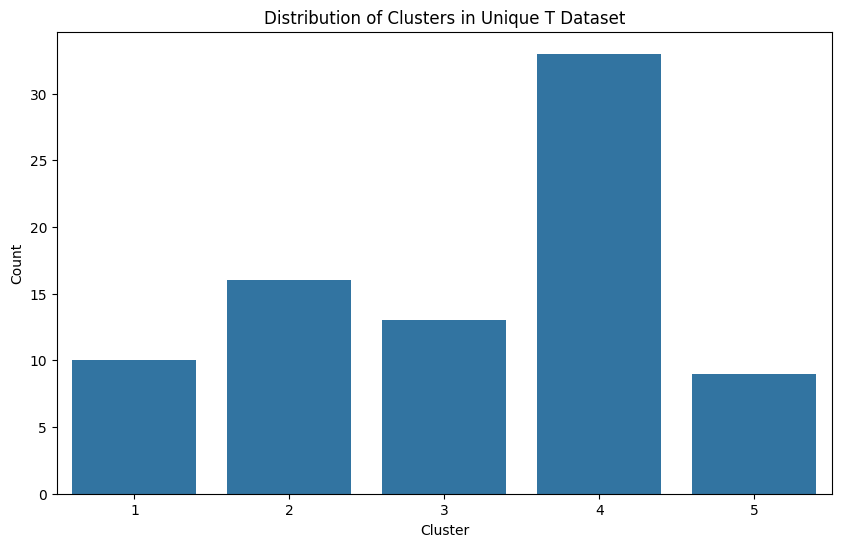

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.barplot(x=(unique_T_df['cluster'].value_counts().index + 1).astype(int), 
            y=unique_T_df['cluster'].value_counts().values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters in Unique T Dataset')
plt.show()

In [36]:
unique_T_df

,source,cluster
0,SPEN,1.0
1,ZBTB8A,2.0
2,MBD6,2.0
3,SNAI2,3.0
4,RARG,0.0
...,...,...
76,GTF2IRD2B,3.0
77,HEY1,3.0
78,HBP1,3.0
79,MEF2D,3.0


In [37]:
unique_T_df.to_csv('../results_final_Jan30/unique_T_df_top10_top100.csv', index=False)

In [39]:
unique_T_df['source']

0          SPEN
1        ZBTB8A
2          MBD6
3         SNAI2
4          RARG
        ...    
76    GTF2IRD2B
77         HEY1
78         HBP1
79        MEF2D
80        TBPL1
Name: source, Length: 81, dtype: object

In [45]:
unique_T_regulated_df = (ranked_df_T_pvals[ranked_df_T_pvals['source'].isin(unique_T_df['source'])]
 .groupby('source')
 .apply(lambda x: x.nlargest(10, 'log10_pval'))
 .reset_index(drop=True))
unique_T_regulated_df.to_csv('../results_final_Jan30/unique_T_regulated_df_top10_top100.csv', index=False)